## Task 1 - Zero-Shot Evaluation

In [1]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.13.7 (main, Aug 15 2025, 12:34:02) [GCC 15.2.1 20250813]
CUDA   : 12.8
Torch  : 2.9.0+cu128
Device : NVIDIA GeForce RTX 4090
Tue Nov 11 04:28:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:1F:00.0 Off |                  Off |
| 33%   39C    P2             75W /  450W |   14719MiB /  24564MiB |      0%      Default |
|   

In [2]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel, logging
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings

/home/course/select/b10401006/tmp2/mai-hw2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# some settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 256 # adjust based on your GPU memory
gradient_accumulation_steps = 1 # adjust based on your GPU memory
# For Linear Probe & LoRA
NUM_EPOCHS = 1
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# CLIP settings
# --- Load CLIP Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
# --- Define a transform to process images for CLIP ---
class CLIPTransform:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, image):
        # The processor expects a PIL image or list of images
        # It returns a dict, we extract 'pixel_values'
        # .squeeze(0) removes the batch dimension the processor adds
        return self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

clip_transform = CLIPTransform(processor)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# dataset related imports
from torchvision.datasets import Flowers102
from datasets import load_dataset
from PIL import Image

# --- Flowers102 ---
# prepare Flowers102 dataset
flowers102_test_dts = Flowers102(root="", split="test", transform=None, download=True)
print(f"Total test samples: {len(flowers102_test_dts)}") # should be 6149

# prepare class names for Flowers102
with open("cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)
# Convert to list indexed by class (0-101), mapping from 1-indexed to 0-indexed
flowers102_class_names = [cat_to_name[str(i+1)] for i in range(102)]
print(f"Number of Flowers102 classes: {len(flowers102_class_names)}")

# Custom dataset wrapper for Flowers102
class Flowers102Dataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

flowers102_test_dataset = Flowers102Dataset(flowers102_test_dts, clip_transform)

# --- CUB-200-2011 ---
birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")
cub_bird_test_dts = birds_200["test"]
print(f"Total test samples: {len(cub_bird_test_dts)}") # should be 5794

# prepare class names for CUB-200-2011
# Extract unique class names from the dataset
cub_bird_class_names = sorted(set(cub_bird_test_dts.features["label"].names))
print(f"Number of CUB-200-2011 classes: {len(cub_bird_class_names)}")

# Create label mapping (label_name to integer)
cub_label_to_idx = {name: idx for idx, name in enumerate(cub_bird_class_names)}

# Custom dataset wrapper for CUB-200-2011
class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform, label_to_idx):
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item["image"]
        if image.mode != "RGB":
            image = image.convert("RGB")
        label = item["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

cub_bird_test_dataset = CUBDataset(cub_bird_test_dts, clip_transform, cub_label_to_idx)

# === Create DataLoaders ===
flowers102_test_loader = DataLoader(flowers102_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
cub_bird_test_loader = DataLoader(cub_bird_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print("DataLoaders created successfully!")

In [12]:
print("--- Starting Method 1: Zero-Shot Classification ---")

# === 1. Load the full CLIP model ===
model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()
print("CLIP model loaded successfully!")

# === 2. Create and encode text prompts ===
def create_text_prompts(class_names, templates=None):
    """
    Create text prompts for zero-shot classification
    Args:
        class_names: list of class names
        templates: list of prompt templates (optional)
    Returns:
        list of prompts
    """
    if templates is None:
        # Use handcrafted prompts following CLIP paper
        templates = [
            "a photo of a {}",
            "a photo of the {}",
        ]
    
    prompts = []
    for class_name in class_names:
        for template in templates:
            prompts.append(template.format(class_name))
    return prompts

# Create prompts for Flowers102
flowers102_prompts = create_text_prompts(flowers102_class_names)
print(f"Created {len(flowers102_prompts)} prompts for Flowers102")

# Encode text prompts for Flowers102
with torch.no_grad():
    flowers102_text_inputs = processor(text=flowers102_prompts, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    flowers102_text_features = model.get_text_features(**flowers102_text_inputs)
    # Reshape to (num_classes, num_templates, feature_dim) and average over templates
    flowers102_text_features = flowers102_text_features.reshape(len(flowers102_class_names), -1, flowers102_text_features.shape[-1]).mean(dim=1)
    # Normalize features
    flowers102_text_features = flowers102_text_features / flowers102_text_features.norm(dim=-1, keepdim=True)

# Create prompts for CUB-200-2011
cub_bird_prompts = create_text_prompts(cub_bird_class_names)
print(f"Created {len(cub_bird_prompts)} prompts for CUB-200-2011")

# Encode text prompts for CUB-200-2011
with torch.no_grad():
    cub_bird_text_inputs = processor(text=cub_bird_prompts, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    cub_bird_text_features = model.get_text_features(**cub_bird_text_inputs)
    # Reshape to (num_classes, num_templates, feature_dim) and average over templates
    cub_bird_text_features = cub_bird_text_features.reshape(len(cub_bird_class_names), -1, cub_bird_text_features.shape[-1]).mean(dim=1)
    # Normalize features
    cub_bird_text_features = cub_bird_text_features / cub_bird_text_features.norm(dim=-1, keepdim=True)


--- Starting Method 1: Zero-Shot Classification ---
CLIP model loaded successfully!
Created 204 prompts for Flowers102
Created 400 prompts for CUB-200-2011


In [ ]:

# === 3. Evaluate on the test set ===

# Evaluate Flowers102
print("\n--- Evaluating Flowers102 ---")
flowers102_predictions = []
flowers102_labels = []
flowers102_images_sample = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(flowers102_test_loader, desc="Zero-Shot Evaluation - Flowers102")):
        images, labels = batch
        images = images.to(DEVICE)
        
        # Get image features
        image_features = model.get_image_features(pixel_values=images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Calculate similarity
        similarity = (100.0 * image_features @ flowers102_text_features.T)
        predictions = similarity.argmax(dim=-1)
        
        flowers102_predictions.extend(predictions.cpu().numpy())
        flowers102_labels.extend(labels.numpy())
        
        # Store some sample images for visualization (first 10)
        if batch_idx < 10:
            flowers102_images_sample.append((images.cpu(), labels.cpu(), predictions.cpu()))

# Evaluate CUB-200-2011
print("\n--- Evaluating CUB-200-2011 ---")
cub_bird_predictions = []
cub_bird_labels = []
cub_bird_images_sample = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(cub_bird_test_loader, desc="Zero-Shot Evaluation - CUB-200-2011")):
        images, labels = batch
        images = images.to(DEVICE)
        
        # Get image features
        image_features = model.get_image_features(pixel_values=images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Calculate similarity
        similarity = (100.0 * image_features @ cub_bird_text_features.T)
        predictions = similarity.argmax(dim=-1)
        
        cub_bird_predictions.extend(predictions.cpu().numpy())
        cub_bird_labels.extend(labels.numpy())
        
        # Store some sample images for visualization (first 10)
        if batch_idx < 10:
            cub_bird_images_sample.append((images.cpu(), labels.cpu(), predictions.cpu()))
    


--- Evaluating Flowers102 ---


Zero-Shot Evaluation - Flowers102:   0%|          | 0/25 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Zero-Shot Evaluation - Flowers102: 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]



--- Evaluating CUB-200-2011 ---


Zero-Shot Evaluation - CUB-200-2011:   0%|          | 0/23 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Zero-Shot Evaluation - CUB-200-2011:  43%|████▎     | 10/23 [00:18<00:20,  1.61s/it]


FLOWERS102 RESULTS
Zero-Shot Test Accuracy: 73.31%

Classification Report:
                           precision    recall  f1-score   support

            pink primrose       0.46      0.95      0.62        20
hard-leaved pocket orchid       0.83      0.75      0.79        40
         canterbury bells       0.21      0.85      0.34        20
                sweet pea       1.00      0.86      0.93        36
         english marigold       0.35      0.40      0.38        45
               tiger lily       0.86      1.00      0.93        25
              moon orchid       0.69      1.00      0.82        20
         bird of paradise       1.00      1.00      1.00        65
                monkshood       1.00      0.88      0.94        26
            globe thistle       0.86      1.00      0.93        25
               snapdragon       0.37      1.00      0.54        67
              colt's foot       1.00      0.58      0.74        67
              king protea       0.96      0.90      

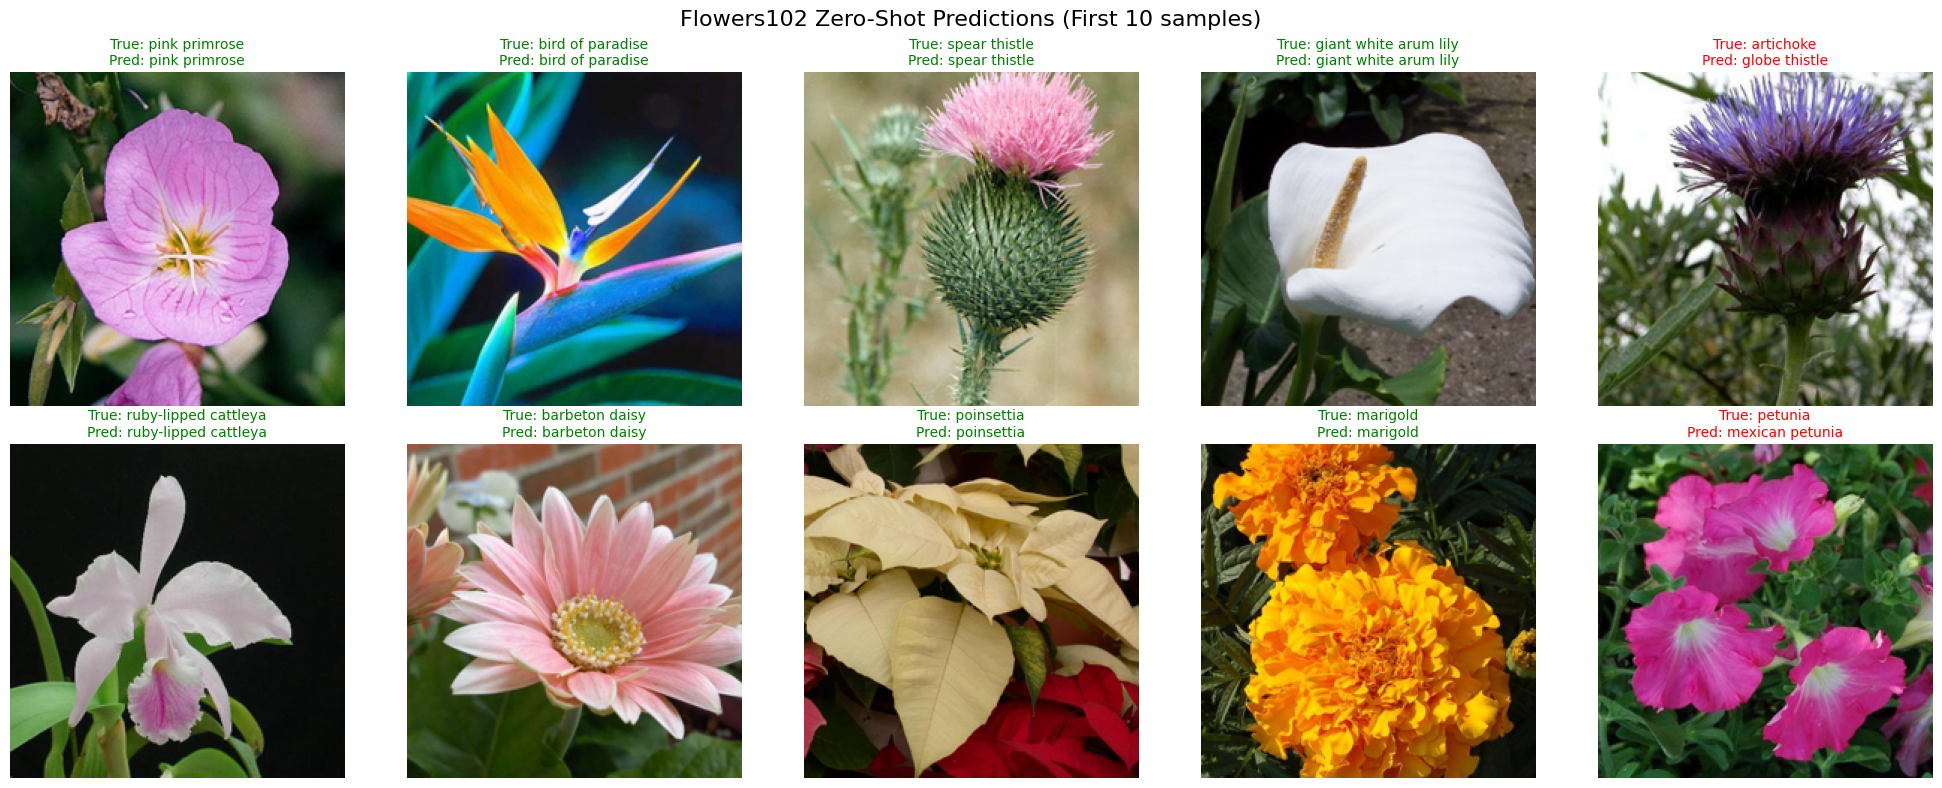


--- Visualizing CUB-200-2011 Predictions ---


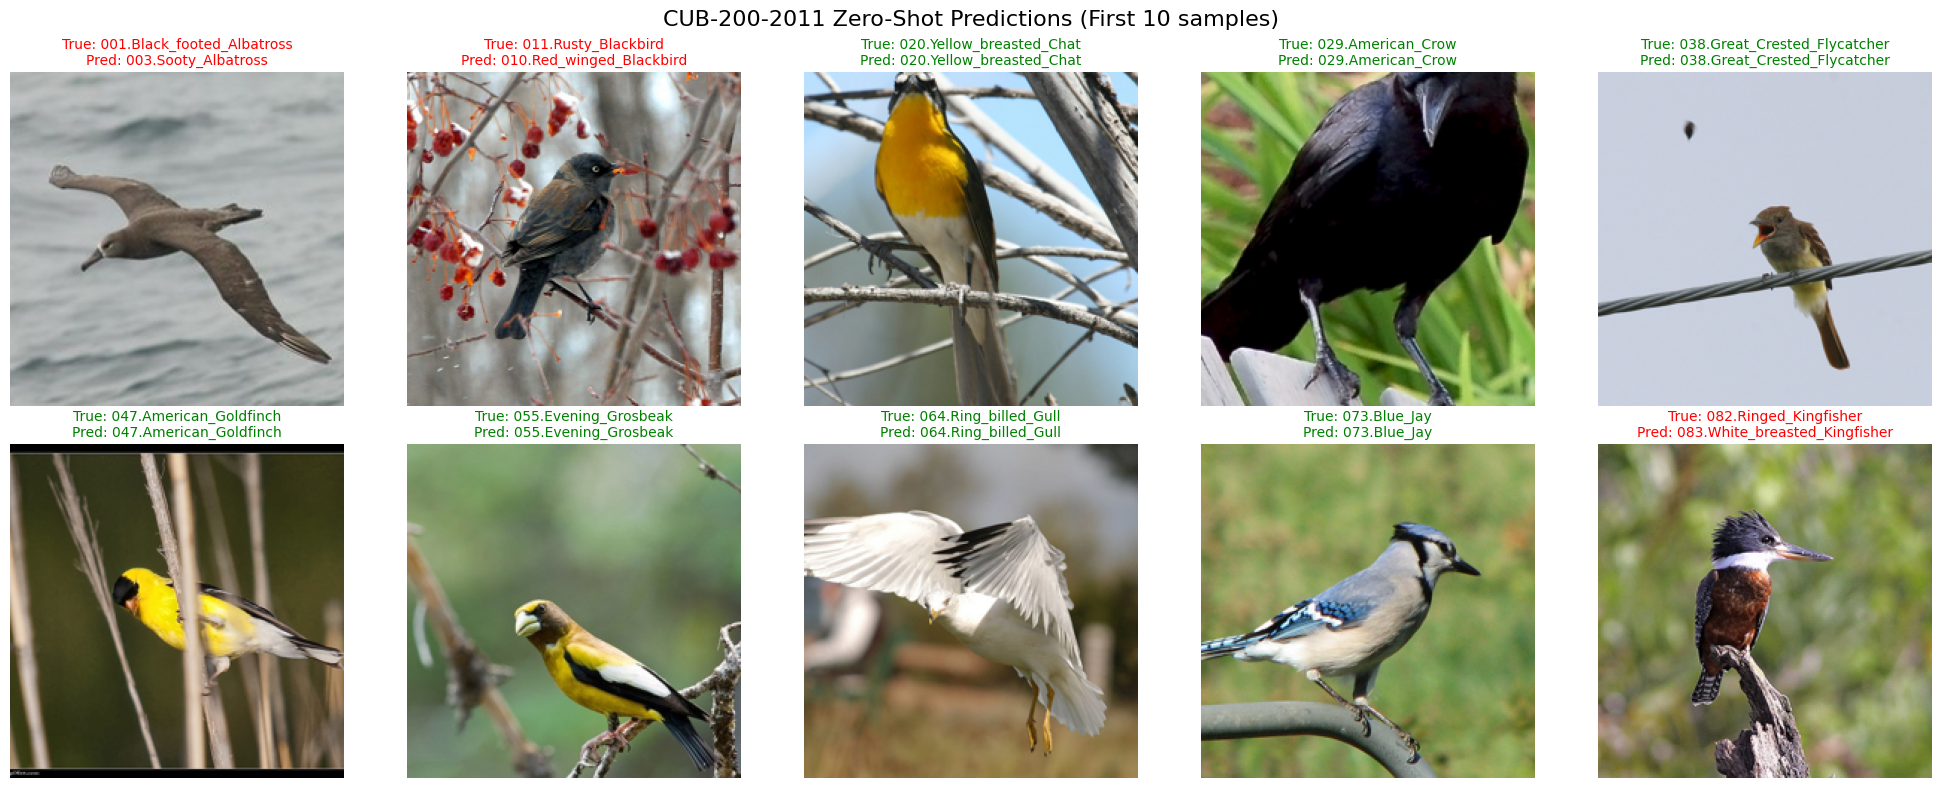

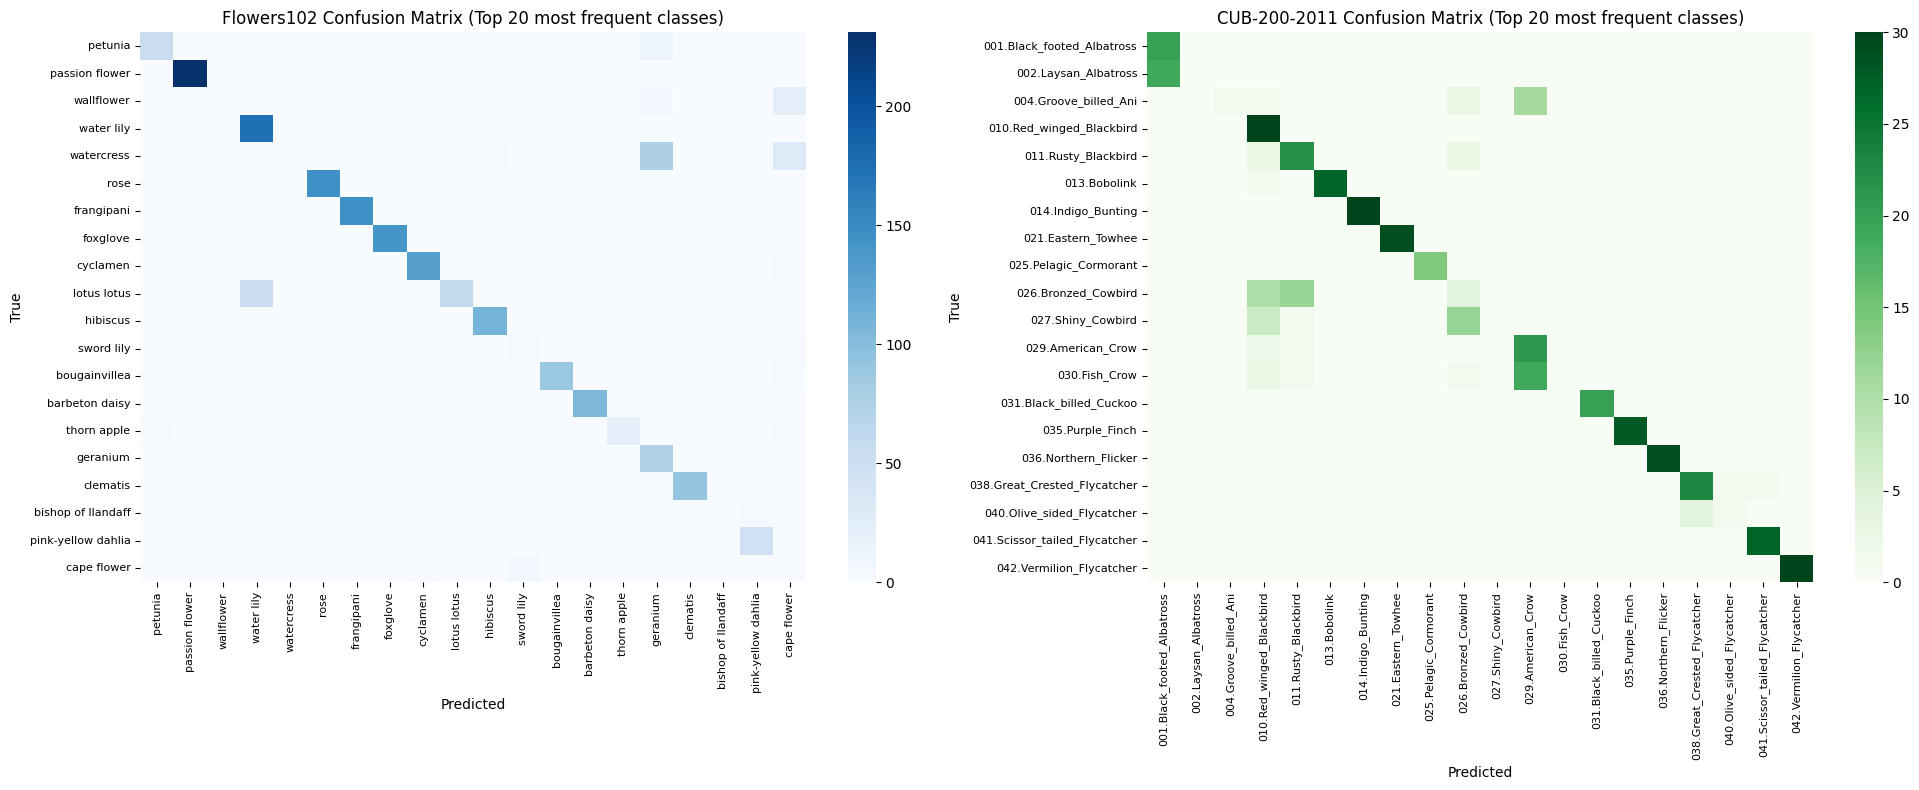


Zero-Shot Evaluation Complete!


In [10]:

# === 4. Result Analysis ===

# Flowers102 metrics
flowers102_predictions = np.array(flowers102_predictions)
flowers102_labels = np.array(flowers102_labels)
flowers102_accuracy = (flowers102_predictions == flowers102_labels).mean()

print("\n" + "="*50)
print("FLOWERS102 RESULTS")
print("="*50)
print(f"Zero-Shot Test Accuracy: {flowers102_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(flowers102_labels, flowers102_predictions, target_names=flowers102_class_names, zero_division=0))

# Confusion matrix for Flowers102
flowers102_cm = confusion_matrix(flowers102_labels, flowers102_predictions)

# CUB-200-2011 metrics
cub_bird_predictions = np.array(cub_bird_predictions)
cub_bird_labels = np.array(cub_bird_labels)
cub_bird_accuracy = (cub_bird_predictions == cub_bird_labels).mean()

print("\n" + "="*50)
print("CUB-200-2011 RESULTS")
print("="*50)
print(f"Zero-Shot Test Accuracy: {cub_bird_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(cub_bird_labels, cub_bird_predictions, target_names=cub_bird_class_names, zero_division=0))

# Confusion matrix for CUB-200-2011
cub_bird_cm = confusion_matrix(cub_bird_labels, cub_bird_predictions)

# === 5. Visualization ===

# Helper function to denormalize images for visualization
def denormalize_image(image_tensor):
    """Convert normalized CLIP image tensor back to displayable format"""
    # CLIP normalizes with mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    image = image_tensor * std + mean
    image = torch.clamp(image, 0, 1)
    return image.permute(1, 2, 0).numpy()

# Visualize Flowers102 predictions
print("\n--- Visualizing Flowers102 Predictions ---")
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Flowers102 Zero-Shot Predictions (First 10 samples)", fontsize=16)
for idx, (images, labels, predictions) in enumerate(flowers102_images_sample[:10]):
    ax = axes[idx // 5, idx % 5]
    image = denormalize_image(images[0])
    ax.imshow(image)
    true_label = flowers102_class_names[labels[0].item()]
    pred_label = flowers102_class_names[predictions[0].item()]
    color = 'green' if labels[0] == predictions[0] else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Visualize CUB-200-2011 predictions
print("\n--- Visualizing CUB-200-2011 Predictions ---")
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("CUB-200-2011 Zero-Shot Predictions (First 10 samples)", fontsize=16)
for idx, (images, labels, predictions) in enumerate(cub_bird_images_sample[:10]):
    ax = axes[idx // 5, idx % 5]
    image = denormalize_image(images[0])
    ax.imshow(image)
    true_label = cub_bird_class_names[labels[0].item()]
    pred_label = cub_bird_class_names[predictions[0].item()]
    color = 'green' if labels[0] == predictions[0] else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Plot confusion matrices (showing a subset for readability)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Flowers102 confusion matrix (show top 20 most frequent classes)
from collections import Counter
flowers_class_counts = Counter(flowers102_labels)
top_20_flower_classes = [cls for cls, count in flowers_class_counts.most_common(20)]
flowers102_cm_subset = flowers102_cm[np.ix_(top_20_flower_classes, top_20_flower_classes)]
top_20_flower_names = [flowers102_class_names[i] for i in top_20_flower_classes]
sns.heatmap(flowers102_cm_subset, annot=False, cmap='Blues', ax=axes[0], cbar=True,
            xticklabels=top_20_flower_names, yticklabels=top_20_flower_names)
axes[0].set_title("Flowers102 Confusion Matrix (Top 20 most frequent classes)", fontsize=12)
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].tick_params(axis='x', rotation=90, labelsize=8)
axes[0].tick_params(axis='y', rotation=0, labelsize=8)

# CUB-200-2011 confusion matrix (show top 20 most frequent classes)
bird_class_counts = Counter(cub_bird_labels)
top_20_bird_classes = [cls for cls, count in bird_class_counts.most_common(20)]
cub_bird_cm_subset = cub_bird_cm[np.ix_(top_20_bird_classes, top_20_bird_classes)]
top_20_bird_names = [cub_bird_class_names[i] for i in top_20_bird_classes]
sns.heatmap(cub_bird_cm_subset, annot=False, cmap='Greens', ax=axes[1], cbar=True,
            xticklabels=top_20_bird_names, yticklabels=top_20_bird_names)
axes[1].set_title("CUB-200-2011 Confusion Matrix (Top 20 most frequent classes)", fontsize=12)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].tick_params(axis='x', rotation=90, labelsize=8)
axes[1].tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Zero-Shot Evaluation Complete!")
print("="*50)